In [1]:
import numpy as np
import torch as torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch.utils import data as data

In [2]:
DATA_FOLDER = "panneaux_route"
CLASSES = { 
    0:"Limitation de vitesse (20km/h)",
    1:"Limitation de vitesse (30km/h)", 
    2:"Limitation de vitesse (50km/h)", 
    3:"Limitation de vitesse (60km/h)", 
    4:"Limitation de vitesse (70km/h)", 
    5:"Limitation de vitesse (80km/h)", 
    6:"Fin de limitation de vitesse (80km/h)", 
    7:"Limitation de vitesse (100km/h)", 
    8:"Limitation de vitesse (120km/h)", 
    9:"Interdiction de depasser", 
    10:"Interdiction de depasser pour vehicules > 3.5t", 
    11:"Intersection ou' vous etes prioritaire", 
    12:"Route prioritaire", 
    13:"Ceder le passage", 
    14:"Arret a' l'intersection", 
    15:"Circulation interdite", 
    16:"Acces interdit aux vehicules > 3.5t", 
    17:"Sens interdit", 
    18:"Danger", 
    19:"Virage a' gauche", 
    20:"Virage a' droite", 
    21:"Succession de virages", 
    22:"Cassis ou dos-d'ane", 
    23:"Chaussee glissante", 
    24:"Chaussee retrecie par la droite", 
    25:"Travaux en cours", 
    26:"Annonce feux", 
    27:"Passage pietons", 
    28:"Endroit frequente' par les enfants", 
    29:"Debouche' de cyclistes", 
    30:"Neige ou glace",
    31:"Passage d'animaux sauvages", 
    32:"Fin des interdictions precedemment signalees", 
    33:"Direction obligatoire a' la prochaine intersection : a' droite", 
    34:"Direction obligatoire a' la prochaine intersection : a' gauche", 
    35:"Direction obligatoire a' la prochaine intersection : tout droit", 
    36:"Direction obligatoire a' la prochaine intersection : tout droit ou a' droite", 
    37:"Direction obligatoire a' la prochaine intersection : tout droit ou a' gauche", 
    38:"Contournement obligatoire de l'obstacle par la droite", 
    39:"Contournement obligatoire de l'obstacle par la gauche", 
    40:"Carrefour giratoire", 
    41:"Fin d'interdiction de depasser", 
    42:"Fin d'interdiction de depasser pour vehicules > 3.5t" 
}


(tensor([[[0.2941, 0.2902, 0.3255,  ..., 0.2627, 0.2549, 0.2588],
         [0.3216, 0.3098, 0.3451,  ..., 0.2863, 0.2980, 0.3098],
         [0.3098, 0.3294, 0.3569,  ..., 0.2824, 0.2902, 0.3059],
         ...,
         [0.4941, 0.4667, 0.4235,  ..., 0.3804, 0.3882, 0.3882],
         [0.3529, 0.3569, 0.3020,  ..., 0.4118, 0.4196, 0.3725],
         [0.3333, 0.3686, 0.2706,  ..., 0.3961, 0.3843, 0.3529]],

        [[0.3059, 0.2980, 0.3294,  ..., 0.2902, 0.2706, 0.2627],
         [0.3255, 0.3176, 0.3412,  ..., 0.3020, 0.3020, 0.3098],
         [0.3098, 0.3294, 0.3490,  ..., 0.2902, 0.2941, 0.3059],
         ...,
         [0.5020, 0.4824, 0.4588,  ..., 0.3765, 0.3961, 0.4039],
         [0.3686, 0.3843, 0.3412,  ..., 0.4078, 0.4353, 0.4039],
         [0.3294, 0.3882, 0.3137,  ..., 0.4000, 0.3961, 0.3804]],

        [[0.3137, 0.3059, 0.3255,  ..., 0.2863, 0.2667, 0.2588],
         [0.3333, 0.3255, 0.3294,  ..., 0.3020, 0.2902, 0.3020],
         [0.3176, 0.3333, 0.3490,  ..., 0.2824, 0.2784, 0

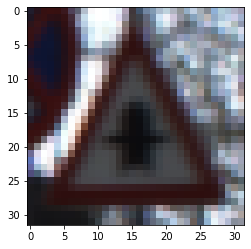

In [3]:
######### DATA SETS #########
from torch.utils.data import Dataset, DataLoader

trainingset = datasets.ImageFolder("panneaux_route/Train", transform=transforms.Compose(
    [transforms.Resize((32,32)),
    transforms.ToTensor()]
))

print(trainingset[0])
print(CLASSES.get(int(trainingset.classes[trainingset[5005][1]]))), plt.imshow(trainingset[5005][0].permute(1,2,0))

trainSize = int(0.8 * len(trainingset))
validationSize = len(trainingset) - trainSize
trainDataset, validationDataset = data.random_split(trainingset, [trainSize, validationSize])

trainLoader = DataLoader(trainDataset, batch_size=256, shuffle=True)
validationLoader = DataLoader(validationDataset, batch_size=1024)

In [19]:
print(trainingset.classes[3])

11


In [4]:
######### COMBIEN DE DONNEES PAR CLASSE #########
def check_repartition(dico, dataset) :
    for images, label in dataset :
        if label in dico :
            dico[label] += 1
        else :
            dico[label] = 1

In [5]:
######### VERIFIONS LA REPARTITION DES DONNEES #########
check_init = {}
check_repartition(check_init, trainingset)

check_traindataset = {}
check_repartition(check_traindataset, trainDataset)

check_valid = {}
check_repartition(check_valid, validationDataset)


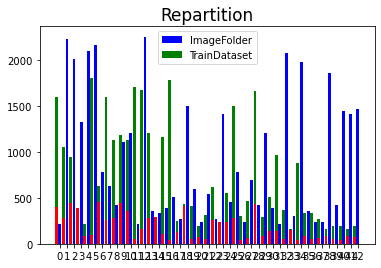

In [6]:
X = np.arange(len(check_init))
ax = plt.subplot(111)
ax.bar(X, check_init.values(), width=0.4, color='b', align='center')
ax.bar(X-0.5, check_traindataset.values(), width=0.4, color='g', align='center')
ax.bar(X-0.5, check_valid.values(), width= 0.4, color='r', align='center')
ax.legend(('ImageFolder','TrainDataset'))
plt.xticks(X, check_init.keys())
plt.title("Repartition", fontsize=17)

plt.show()

In [232]:
def validate_soft(predictions, labels):
    nb_errors = ((predictions.argmax(1)) != labels).sum()
    return (len(predictions)-nb_errors).item()

######### TRAIN LOOP #########
def train_loop(train_loader, model, loss_map, lr=1e-3, epochs=20):
    history = []
    # use gpu if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    # create optimizer
    optimizer = Adam(model.parameters(), lr=lr)
    # Train model
    for epoch in range(epochs):
        loss_epoch = 0.
        train_acc = 0.
        model.train()
        for images, labels in train_loader:
            # Transfers data to GPU
            #images, labels = images.to(device), labels.to(device)
            # Primal computation
            output = model(images)             
            loss = loss_map(output, labels)           
            # Gradient computation
            model.zero_grad()
            loss.backward()
            # perform parameter update based on current gradients
            optimizer.step()
            # compute the epoch training loss
            loss_epoch += loss.item()
            train_acc += validate_soft(output, labels)
            remplir_taux(output, labels)
        # display the epoch training loss
        model.eval()
        test_acc = validate(validationLoader, model)
        train_acc = 100*train_acc/len(train_loader.dataset)
        history.append(
            {'epoch' : epoch + 1,
             'loss' : loss_epoch,
             'train_acc' : train_acc,
             'test_acc' : test_acc})
        print(f"epoch : {epoch + 1}/{epochs}, loss = {loss_epoch:.6f}, train_acc = {train_acc}, test_acc = {test_acc}%")
    return history

In [233]:
######### VALIDATION #########
def validate(data_loader, model):
    nb_errors = 0
    nb_tests = 0
    for i, (images, labels) in enumerate(data_loader):
        output = model(images)
        nb_errors += ((output.argmax(1)) != labels).sum()
        nb_tests += len(images)
    return (100*(nb_tests-nb_errors)) / nb_tests

def validate2(data_loader, model):
    nb_errors = 0
    nb_tests = 0
    for i, (images, labels) in enumerate(data_loader):
        output = model(images.view(-1, 3, 32, 32)).argmax(1)
        predictions = []
        for prediction in output.tolist() :
            predictions.append(trainingset.classes[prediction])

        for i in range(len(predictions)) :
            if int(predictions[i]) != int(labels[i]) :
                nb_errors += 1
        nb_tests += len(images)
    
    return (100*(nb_tests-nb_errors)) / nb_tests

In [234]:
######### MODEL(S) #########
class LeNet5(nn.Module):
    def __init__(self, dropout=0.0):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5))
        self.dropout1 = nn.Dropout2d(p=dropout)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5,5))
        self.dropout2 = nn.Dropout2d(p=dropout)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=(5,5))
        self.dropout3 = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(120, 92)
        self.dropout4 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(92, 68)
        self.fc3 = nn.Linear(68, 43)

    def forward(self, input):
        layer1 = F.relu(self.conv1(input))                        
        layer2 = F.max_pool2d(layer1, kernel_size=(2, 2), stride=2)
        layer2_d = self.dropout1(layer2)
        layer3 = F.relu(self.conv2(layer2_d))                         
        layer4 = F.max_pool2d(layer3, kernel_size=(2, 2), stride=2) 
        layer4_d = self.dropout1(layer4)
        layer5 = F.relu(self.conv3(layer4_d))  
        layer5_d = self.dropout3(layer5)                                
        layer6 = F.relu(self.fc1(torch.flatten(layer5_d,1)))
        layer8 = F.relu(self.fc2(layer6))
        layer9 = self.dropout4(layer8)        
        layer7 = self.fc3(layer9)                                   
        return layer7


In [235]:
lenet = LeNet5(0.4)
h = train_loop(
    train_loader=trainLoader, 
    model=lenet, 
    loss_map=nn.CrossEntropyLoss(),
    lr=0.003,
    epochs=5)

cpu
epoch : 1/5, loss = 424.248627, train_acc = 7.3134185609079605, test_acc = 22.570772171020508%
epoch : 2/5, loss = 284.614522, train_acc = 29.22816973252144, test_acc = 47.62815475463867%
epoch : 3/5, loss = 214.900607, train_acc = 43.689227532119745, test_acc = 62.050498962402344%
epoch : 4/5, loss = 178.074528, train_acc = 53.18009372907833, test_acc = 72.6600341796875%
epoch : 5/5, loss = 156.361907, train_acc = 59.41913475946058, test_acc = 77.69701385498047%


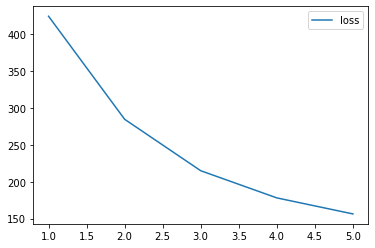

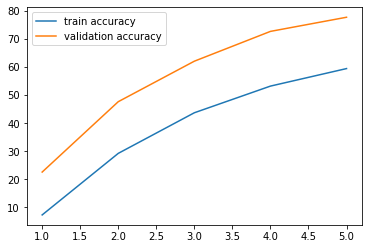

0.7317073170731708
40.88863892013499
73.71714643304131
52.639545884579
68.48048048048048
78.55549031121551
52.63327948303716
22.33663366336634
23.543543543543542
66.94063926940639
43.941908713692946
0.36363636363636365
30.776914539400668
0.13745704467353953
0.3731343283582089
24.774193548387096
3.990384615384615
0.8333333333333334
54.38741721854304
1.8454935622317596
4.020618556701031
1.1085450346420322


KeyError: 22

In [237]:
import math
def show_loss(history) :
    fig, ax = plt.subplots()
    ax.plot([h['epoch'] for h in history], [h['loss'] for h in history], label='loss')
    plt.legend()
    plt.show()
def show_learning(history):
    fig, ax = plt.subplots()
    ax.plot([h['epoch'] for h in history], [h['train_acc'] for h in history], label='train accuracy')
    ax.plot([h['epoch'] for h in history], [h['test_acc'] for h in history], label='validation accuracy')
    plt.legend()
    plt.show()
show_loss(h)
show_learning(h)
for i in range(0, 43) :
    print(f"{100*(taux_par_classe[i]/total_par_classe[i])}")
print(taux_par_classe, total_par_classe)

In [159]:
######### FINAL TEST #########
df = pd.read_csv('panneaux_route/Test.csv', sep=',')
trans = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
labels = df['ClassId'].tolist()
images = df['Path'].tolist()
img_lst = []

for img in images :
    img = "panneaux_route/" + img
    img_lst.append(trans(Image.open(img)))

In [160]:
class MyDataSet(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

In [161]:
test_dataset = MyDataSet(img_lst, labels)
test_dataloader = DataLoader(test_dataset, batch_size=256)
print(f"Model after learning 2 validate -> accuracy = {validate(test_dataloader, lenet)}%")

Model after learning 2 validate -> accuracy = 5.764053821563721%


['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']
16
tensor([16,  1, 38, 33, 11, 38, 18, 12, 25, 35, 12,  7, 23,  7,  4,  9, 21, 20,
        27, 38,  4, 33,  9,  3,  1, 11, 13, 10,  9, 11,  5, 17, 34, 23,  2, 17,
         3, 12, 16,  8,  7, 30, 18, 12, 24, 25,  3, 10, 18,  8, 25, 13, 15,  9,
        13, 35,  5, 26,  9, 16, 38, 10,  4,  9, 15,  9, 26,  2,  5, 28, 11, 25,
        30, 34,  5, 12,  1, 10, 25, 25, 21, 33, 25,  7, 10, 35,  3,  7, 22, 13,
         3,  1,  2, 14, 12, 32,  3, 38,  9, 33,  1, 10,  5, 11, 33,  4, 35, 25,
        33,  4,  1, 14, 16, 10, 30,  3, 27, 29,  1, 17, 13,  7,  1,  8,  2, 10,
        10, 30,  1,  6, 36,  3, 14, 13, 11, 10, 18, 40,  2, 38, 41,  4,  6, 18,
        17, 25,  2, 41, 11, 21,  7, 24, 11, 25, 17,  3,  6,  9,  7,  4, 13, 16,
         4, 25, 18,  9, 13, 

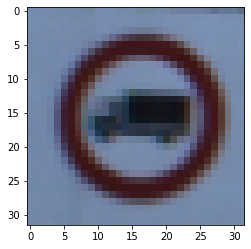

In [162]:
count = 0
for i, (images, labels) in enumerate(test_dataloader):
    if count > 0 : break
    for img in images : 
        plt.imshow(img.permute(1,2,0))
        break
    predictions = lenet(images.view(-1, 3, 32, 32)).argmax(1)

    print(trainingset.classes)
    print(trainingset.classes[8])
    print(labels)
    count+=1


In [163]:
def validate2(data_loader, model):
    nb_errors = 0
    nb_tests = 0
    for i, (images, labels) in enumerate(data_loader):
        output = model(images.view(-1, 3, 32, 32)).argmax(1)
        predictions = []
        for prediction in output.tolist() :
            predictions.append(trainingset.classes[prediction])

        for i in range(len(predictions)) :
            if int(predictions[i]) != int(labels[i]) :
                nb_errors += 1
        nb_tests += len(images)
    
    return (100*(nb_tests-nb_errors)) / nb_tests

In [164]:
print(validate2(test_dataloader, lenet))

89.2319873317498


In [97]:
def train_loop2(
    train_loader, 
    validation_loader,  # for monitoring overfitting
    model, 
    loss_map, 
    validation_map,     # for monitoring overfitting
    lr=1e-3, 
    epochs=20,
    weight_decay=0.0):  # a regularisation parameter, discussed later
    # use gpu if available    
    # create optimizer
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)    # weight_decay, discussed later

    # Train model    
    history = [] # to monitor learning: list of  {epoch: int, loss: float, train_acc:float, val_acc:float}
    for epoch in range(epochs):
        loss_epoch = 0.
        train_acc = 0.
        val_acc = 0.
        model.train()   # for dropout and batch normalisation, discussed later
        for images, labels in train_loader:
            # Transfers data to GPU
            # images, labels = images.to(device), labels.to(device)
            # Primal computation
            output = model(images)            
            loss = loss_map(output, labels)            
            # Gradient computation
            model.zero_grad()
            loss.backward()
            # perform parameter update based on current gradients
            optimizer.step()
            # compute the epoch training loss
            loss_epoch += loss.item()
            train_acc += validate_soft(output, labels)
        # compute validation accuracy
        model.eval()    # for dropout and batch normalisation, discussed later
        with torch.no_grad():
            for images, labels in validation_loader:
                # Transfers data to GPU
                # images, labels = images.to(device), labels.to(device)
                val_acc += validate_soft(model(images), labels)
            train_acc = 100*train_acc/len(train_loader.dataset)
            val_acc = 100*val_acc/len(validation_loader.dataset)
        history.append({"epoch" : epoch, "loss" : loss_epoch, "train_acc" : train_acc, "val_acc" : val_acc})
        if epoch % 10 == 9 or epoch == 0:
            print(f"epoch : {epoch + 1}/{epochs}, loss = {loss_epoch:.6f}, train_acc = {train_acc:.2f}, val_acc = {val_acc:.2f}")
    return history


def show_history2(history):
    figure, axis = plt.subplots(1, 2)
    axis[0].plot([d["epoch"] for d in history], [d["loss"] for d in history])
    axis[0].set_title("Loss per epoch")

    axis[1].plot([d["epoch"] for d in history], [d["train_acc"] for d in history], label="train")
    axis[1].plot([d["epoch"] for d in history], [d["val_acc"] for d in history], label="validation")
    axis[1].set_title("Accuracy per epoch")

    plt.legend()

In [98]:
# 2. dropout
class Net3(nn.Module):
    def __init__(self,dropout_p=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3))    
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3))
        self.dropout1 = nn.Dropout(p=dropout_p) # as attribute, to be activated/disactivated by model.eval()/train()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))    
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3)) 
        self.dropout2 = nn.Dropout(p=dropout_p) # as attribute, to be activated/disactivated by model.eval()/train()
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3))    
        self.conv6 = nn.Conv2d(128, 128, kernel_size=(3, 3)) 
        self.dropout3 = nn.Dropout(p=dropout_p) # as attribute, to be activated/disactivated by model.eval()/train()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 43)

    def forward(self, input):
        layer1 = F.relu(self.conv1(input))                  
        layer2 = F.relu(self.conv2(layer1))
        layer3 = F.max_pool2d(layer2, kernel_size=2, stride=2)
        layer3_d = self.dropout1(layer3)
        layer4 = F.relu(self.conv3(layer3_d))                  
        layer5 = F.relu(self.conv4(layer4))            
        layer6 = F.max_pool2d(layer5, kernel_size=2, stride=2)
        layer6_d = self.dropout2(layer6)
        layer7 = F.relu(self.conv5(layer6_d))                  
        layer8 = F.relu(self.conv6(layer7))
        layer8_d = self.dropout3(layer8)            
        layer9 = F.relu(self.fc1(torch.flatten(layer8_d,1)))  
        layer10 = self.fc2(layer9)                        
        return layer10

print("Net3, full data-set, weight-decay and dropout")
net = Net3(dropout_p=0.4)
# in dropout, crucial learning/validation uses resp. 
# into model.train() and model.eval()
history = train_loop2(
    train_loader=trainLoader, 
    validation_loader=validationLoader,
    model=net, 
    loss_map=nn.CrossEntropyLoss(),
    validation_map=validate,
    lr=0.001,
    epochs=100,
    weight_decay=0.0005)

show_history2(history)
# Dropout is a powerful regularisation technique
# we loose a loss on train_acc: from ~97% to ~81%
# but we gain a lot in val_acc: from ~74% to ~80%

Net3, full data-set, weight-decay and dropout
epoch : 1/100, loss = 422.933179, train_acc = 6.98, val_acc = 14.46
epoch : 10/100, loss = 31.164543, train_acc = 92.05, val_acc = 97.31


KeyboardInterrupt: 